# Basic Framework

In [ ]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation
import pandas as pd # to deal with dataframes
import os 
import gc
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural networks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import Dataset, DataLoader # For making datasets
from PIL import Image # For opening images from given path
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# GPU is preffered 

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')     # Please comment out of the code if you are manually uploading the files

Mounted at /content/drive


In [ ]:
num_epochs = 50 # Please set this according to your resources and training time
num_epochs_b = 50 # Please set this according to your resources and training time

In [ ]:
os.chdir('/')
os.chdir('content/drive/MyDrive/project') 
path = %pwd
print(path) # Make sure path contains the location of the main folder containing the data
train_df = pd.read_csv(path + '/Memotion2/memotion_train.csv')
val_df = pd.read_csv(path + '/Memotion2/memotion_val.csv')
test_df = pd.read_csv(path + '/memotion2_test/memotion_test.csv')
train_df.head()

/content/drive/MyDrive/project


,Id,Image url,ocr_text,humour,sarcastic,offensive,motivational,overall_sentiment,classification_based_on
0,1,https://preview.redd.it/9jkzlvt8p4q31.jpg?widt...,enters into a wrong class teacher and students,funny,not_sarcastic,slight,not_motivational,neutral,image_and_text
1,2,https://i.pinimg.com/originals/fd/c8/e2/fdc8e2...,dj if you single make some nooooissssseeee my ...,funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text
2,3,https://i.pinimg.com/originals/85/10/13/851013...,everyone sit like a lady me,funny,not_sarcastic,slight,not_motivational,neutral,image_and_text
3,4,https://i.imgur.com/07ZcrjZ_d.webp?maxwidth=52...,when youre about to watch a 2 hour educational...,funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text
4,5,https://i.imgur.com/MGddJxr_d.jpg?maxwidth=520...,government work from home olympic swimmers nsdf,very_funny,little_sarcastic,not_offensive,not_motivational,neutral,image_and_text


Adding a new column for image path

In [ ]:
train_df['img_path'] = path + '/image folder/train_images/' + train_df['Id'].astype(str) + '.jpg'
val_df['img_path'] = path + '/image folder/val_images/' + val_df['Id'].astype(str) + '.jpg'
test_df['img_path'] = path + '/Test Images/Test Images/' + test_df['Id'].astype(str) + '.jpg'

label maps for all the three tasks resepectively. Used it for encoding the label to interger and one hot vectors 

In [ ]:
label_map1 = {     # For multi-class classification
    "neutral":1,
    "negative":0,
    "very_negative":0,
    "positive":2
}
label_map2 = {'funny': 0,       # multi-label classification
             'very_funny': 0,
             'not_funny': 0,
             'hilarious': 0,
             'not_sarcastic': 1,
             'little_sarcastic': 1,
             'very_sarcastic': 1,
             'extremely_sarcastic': 1,
             'slight': 2,
             'not_offensive': 2,
             'very_offensive': 2,
             'hateful_offensive': 2,
             'not_motivational': 3,
             'motivational': 3
             }
label_map3 = {'funny': 0,        # multi - task classfication
             'very_funny': 1,    # converting the original labels to 1 to 14
             'not_funny': 2,
             'hilarious': 3,
             'not_sarcastic': 4,
             'little_sarcastic': 5,
             'very_sarcastic': 6,
             'extremely_sarcastic': 7,
             'slight': 8,
             'not_offensive': 9,
             'very_offensive': 10,
             'hateful_offensive': 11,
             'not_motivational': 12,
             'motivational': 13
             }

In [ ]:
test_df.head()

,Id,Image url,ocr_text,classification_based_on,img_path
0,1,https://i.pinimg.com/originals/0c/4d/c3/0c4dc3...,women are so hard to read well actually we jus...,image_and_text,/content/drive/MyDrive/project/Test Images/Tes...
1,2,https://i.imgur.com/OeRleMX_d.webp?maxwidth=52...,when you are trying to hold a fart next to you...,image_and_text,/content/drive/MyDrive/project/Test Images/Tes...
2,3,https://chameleonmemes.com/wp-content/uploads/...,my girlfriend me,image_and_text,/content/drive/MyDrive/project/Test Images/Tes...
3,4,https://i.imgur.com/QchtYd8_d.webp?maxwidth=52...,wworld star fans she ran like frozone from th...,image_and_text,/content/drive/MyDrive/project/Test Images/Tes...
4,5,https://i.imgur.com/h2BXkxe_d.webp?maxwidth=52...,if you stopped time youd be blind because ligh...,image_and_text,/content/drive/MyDrive/project/Test Images/Tes...


In [ ]:
# taskA column contains encoded label correspoinding for task A
train_df['taskA'] = None
val_df['taskA'] = None
for i in range(train_df.shape[0]):
    x = 0
    s = train_df.iloc[i]['overall_sentiment']
    x = label_map1[s]
    train_df.at[i,'taskA'] = x
for i in range(val_df.shape[0]):
    x = 0
    s = val_df.iloc[i]['overall_sentiment']
    x = label_map1[s]
    val_df.at[i,'taskA'] = x

Creating a new column multi_label which is a list of values of humour,sarcastic,offensive,motivational columns of the data frame

In [ ]:
train_df['multi_label'] = train_df.apply(lambda row: [row['humour'],row['sarcastic'],row['offensive'],row['motivational']],axis = 1)
val_df['multi_label'] = val_df.apply(lambda row: [row['humour'],row['sarcastic'],row['offensive'],row['motivational']],axis = 1)

In [ ]:
# taskB column contains encoded label correspoinding for task B
train_df['taskB'] = None
val_df['taskB'] = None
for i in range(train_df.shape[0]):
    x = np.zeros(4)
    for s in train_df.iloc[i]['multi_label']:
        if "not" in s:
            x[label_map2[s]] = 0
        else:
            x[label_map2[s]] = 1
    train_df.at[i,'taskB'] = x

for i in range(val_df.shape[0]):
    x = np.zeros(4)
    for s in val_df.iloc[i]['multi_label']:
        if "not" in s:
            x[label_map2[s]] = 0
        else:
            x[label_map2[s]] = 1
    val_df.at[i,'taskB'] = x

In [ ]:
# taskC column contains encoded label correspoinding for task C
train_df['taskC'] = None
val_df['taskC'] = None
for i in range(train_df.shape[0]):
    x = np.zeros(14)
    for s in train_df.iloc[i]['multi_label']:
        x[label_map3[s]] = 1
    train_df.at[i,'taskC'] = x

for i in range(val_df.shape[0]):
    x = np.zeros(14)
    for s in val_df.iloc[i]['multi_label']:
        x[label_map3[s]] = 1
    val_df.at[i,'taskC'] = x

Checking for null values in the dataframe

In [ ]:
train_df.isnull().any()

Id                         False
Image url                  False
ocr_text                   False
humour                     False
sarcastic                  False
offensive                  False
motivational               False
overall_sentiment          False
classification_based_on    False
img_path                   False
taskA                      False
multi_label                False
taskB                      False
taskC                      False
dtype: bool

In [ ]:
val_df.isnull().any()

Id                         False
Image url                  False
ocr_text                   False
humour                     False
sarcastic                  False
offensive                  False
motivational               False
overall_sentiment          False
classification_based_on    False
img_path                   False
taskA                      False
multi_label                False
taskB                      False
taskC                      False
dtype: bool

In [ ]:
train_df.head(1)

,Id,Image url,ocr_text,humour,sarcastic,offensive,motivational,overall_sentiment,classification_based_on,img_path,taskA,multi_label,taskB,taskC
0,1,https://preview.redd.it/9jkzlvt8p4q31.jpg?widt...,enters into a wrong class teacher and students,funny,not_sarcastic,slight,not_motivational,neutral,image_and_text,/content/drive/MyDrive/project/image folder/tr...,1,"[funny, not_sarcastic, slight, not_motivational]","[1.0, 0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."


Defining MemesDataSet class for generating datasets for all the three tasks

In [ ]:
class MemesDataSet(Dataset):

    def __init__(self, data_frame, root_dir,subtask,transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform   # image transform
        self.subtask = subtask  # which task are we dealing in the given three tasks
        self.images = []

        # We are storing the images in the __init__ method so that we need not laod and transform the 
        # images everytime the __getitem__ method is initiated which saves time and we can run for more epochs.
        # But this comes at the cost of memory, since we are storing all the 7000 images in the init method.
        # It consumes a lot of memory.
        for i in range(self.data_frame.shape[0]):
          if subtask == 'test':
            temp_image = Image.open(os.path.join(self.root_dir, self.data_frame.iloc[i, -1]))
            temp_image = temp_image.convert('RGB')
            self.images.append(self.transform(temp_image))
          else:
            temp_image = Image.open(os.path.join(self.root_dir, self.data_frame.iloc[i, -5]))
            temp_image = temp_image.convert('RGB')
            self.images.append(self.transform(temp_image))

    def __len__(self):
        # Return the length of the dataset
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        
        if self.subtask == 'A':
          label = self.data_frame.iloc[idx, -4]
        elif self.subtask == 'B':
          label = self.data_frame.iloc[idx, -2]
        elif self.subtask == 'C':
          label = self.data_frame.iloc[idx, -1]
        else:
          return self.images[idx]

        return (self.images[idx], label)
    
    def update_subtask(self, subtask):
      self.subtask = subtask

In [ ]:
# typical image transformation
transform = transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean = (0.485,0.456,0.406),
                std = (0.229,0.224,0.225))]
)

In [ ]:
test_df.shape

(1500, 5)

In [ ]:
testset = MemesDataSet(
    data_frame = test_df,
    root_dir = '',
    subtask = 'test',
    transform = transform
)

common_trainset = MemesDataSet(
    data_frame = train_df,
    root_dir = '',
    subtask = None,
    transform = transform
)

common_valset = MemesDataSet(
    data_frame = val_df,
    root_dir = '',
    subtask = None,
    transform = transform
)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
import pickle
# Saving datasets as it takes lot of time to process them
with open('./testset.pickle', 'wb') as handle:
    pickle.dump(testset, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./common_trainset.pickle', 'wb') as handle:
    pickle.dump(common_trainset, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./common_valset.pickle', 'wb') as handle:
    pickle.dump(common_valset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('testset.pickle', 'rb') as handle:
    testset = pickle.load(handle)
with open('common_trainset.pickle', 'rb') as handle:
    common_trainset = pickle.load(handle)
with open('common_valset.pickle', 'rb') as handle:
    common_valset = pickle.load(handle)

In [ ]:
test_df['taskA'] = None
test_df['taskB'] = None
test_df['taskC'] = None

# Task A

In [ ]:
# Generating trainingset for taskA
trainset = common_trainset
trainset.update_subtask('A')
valset = common_valset
valset.update_subtask('A')

Loading data into DataLoaders and initializing it's hyper parameters

In [ ]:
# set batch_size
batch_size = 16

# load train data
traindataloader = DataLoader(trainset, batch_size = batch_size,
                            shuffle=True)

# load test data
valdataloader = DataLoader(valset, batch_size = 64,
                        shuffle=False)

classes = ('neutral','positive','negative')

In [ ]:
# Basic Convolutional Model Architecture
class ConvNet(nn.Module):

    ''' Models a simple Convolutional Neural Network '''
	
    def __init__(self):
        ''' initialize the network '''
        super(ConvNet, self).__init__()
        # 3 input image channel, 6 output channels,
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3,6,5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 20, 4)
        self.fc1 = nn.Linear(20 * 25 * 25, 256) # Computationally heavy layer since we have 20*25*25*256 parameters in the layer
        # self.fc2 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 3) # Ouput layer consists of 3 neurons
        self.logsoftmax = nn.LogSoftmax(dim = 1) # Since it is multi-class classification we used Softmax/LogSoftmax

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 20 * 25 * 25)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.logsoftmax(self.fc2(x))
        return x


In [ ]:
net = ConvNet()
net.to(device)
print(net)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=12500, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


Training the model

In [ ]:
next(net.parameters()).is_cuda

True

In [ ]:
criterion = nn.NLLLoss()  # using NLL Loss
optimizer = optim.Adam(net.parameters(), lr=0.0001) # Adam Optimiser

for epoch in range(20):  # loop over the dataset multiple times

    for i, data in enumerate(traindataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(device)
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        if i % 80 == 79:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))


[1,    80] loss: 0.827
[1,   160] loss: 0.963
[1,   240] loss: 0.769
[1,   320] loss: 1.017
[1,   400] loss: 0.895
[2,    80] loss: 1.041
[2,   160] loss: 0.557
[2,   240] loss: 1.089
[2,   320] loss: 0.815
[2,   400] loss: 0.682
[3,    80] loss: 1.070
[3,   160] loss: 0.676
[3,   240] loss: 0.774
[3,   320] loss: 1.008
[3,   400] loss: 0.911
[4,    80] loss: 0.858
[4,   160] loss: 0.643
[4,   240] loss: 0.731
[4,   320] loss: 0.797
[4,   400] loss: 0.551
[5,    80] loss: 1.027
[5,   160] loss: 0.994
[5,   240] loss: 0.819
[5,   320] loss: 0.805
[5,   400] loss: 0.643
[6,    80] loss: 0.725
[6,   160] loss: 0.608
[6,   240] loss: 0.503
[6,   320] loss: 1.100
[6,   400] loss: 0.637
[7,    80] loss: 0.742
[7,   160] loss: 0.918
[7,   240] loss: 0.721
[7,   320] loss: 0.758
[7,   400] loss: 0.760
[8,    80] loss: 0.520
[8,   160] loss: 0.693
[8,   240] loss: 0.833
[8,   320] loss: 0.333
[8,   400] loss: 0.699
[9,    80] loss: 0.698
[9,   160] loss: 0.457
[9,   240] loss: 0.641
[9,   320] 

In [ ]:
# saving the multi-class model net
net = net.to('cpu')
torch.save(net.state_dict(),'./net.pth')
net = net.to(device)

Evaluating the model

In [ ]:
# Evaluation mode
net.eval()
correct = 0
total = 0
all_labels = []
all_predicted = []
with torch.no_grad():
    for data in valdataloader:
        images, labels = data
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.to('cpu')
        all_labels.append(labels)
        all_predicted.append(predicted)
    a1,a2 = all_labels,all_predicted
    a1 = torch.cat(a1)
    a2 = torch.cat(a2)
    print(f'F1 score is {np.mean(f1_score(a1,a2,average = None))}') # Printing F1 score
    print(f'Accuracy score is {np.mean(accuracy_score(a1,a2))}') # Printing accuracy_score


F1 score is 0.33380429135703354
Accuracy score is 0.516


**Incase if generating trainset and valset is taking time, I'm loading my trained model here with which you can directly run it on test dataloader**

In [ ]:
# loading the model
net = ConvNet()
net.load_state_dict(torch.load('./net.pth'))
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=12500, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

Implementing on test data 

In [ ]:
testloader = DataLoader(testset,batch_size = 64,shuffle = False)
with torch.no_grad():
    all_predicted = []
    for data in testloader:
      data = data.to(device)
      outputs = net(data)
      _,predicted = torch.max(outputs.data,1)
      predicted = predicted.to('cpu')
      all_predicted.append(predicted)
    a1 = torch.cat(all_predicted)
    test_df['taskA'] = a1
test_df.to_csv("./taskA_test_results.csv")

In [ ]:
test_df.head(2)

,Id,Image url,ocr_text,classification_based_on,img_path,taskA,taskB,taskC
0,1,https://i.pinimg.com/originals/0c/4d/c3/0c4dc3...,women are so hard to read well actually we jus...,image_and_text,/content/drive/MyDrive/project/Test Images/1.jpg,1,None,None
2,3,https://chameleonmemes.com/wp-content/uploads/...,my girlfriend me,image_and_text,/content/drive/MyDrive/project/Test Images/3.jpg,1,None,None


0

# Task B

Generating training sets for task B

In [ ]:
# Generating training sets for task B
train_task2_set = common_trainset
train_task2_set.update_subtask('B')
val_task2_set = common_valset
val_task2_set.update_subtask('B')

Loading data into DataLoaders and initializing it's hyper parameters

In [ ]:
# set batch_size
batch_size = 16

# load train data
traintask2loader = DataLoader(train_task2_set, batch_size=batch_size,
                            shuffle=True)

# load test data
valtask2loader = DataLoader(val_task2_set, batch_size = 64,
                        shuffle=False)

In [ ]:
# defining the Model Architecture for task B
class ConvTask2Net(nn.Module):

    ''' Models a simple Convolutional Neural Network '''
	
    def __init__(self):
        ''' initialize the network '''
        super(ConvTask2Net, self).__init__()
        # 3 input image channel, 6 output channels,
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3,6,5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 20, 4)
        self.fc1 = nn.Linear(20 * 25 * 25, 256) # Computationally heavy layer since we have 20*25*25*256 parameters in the layer
        # self.fc2 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 4) # Ouput layers has 4 neurons
        self.sigmoid = nn.Sigmoid()  # Since it is a multi-label classification we used Sigmoid

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 20 * 25 * 25)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [ ]:
multilabel_model = ConvTask2Net()
multilabel_model.to(device)
print(multilabel_model)

ConvTask2Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=12500, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (sigmoid): Sigmoid()
)


Training the model for task B

In [ ]:
next(multilabel_model.parameters()).is_cuda

True

In [ ]:
criterion = nn.BCELoss() # using BCE Loss
optimizer = optim.Adam(multilabel_model.parameters(), lr=0.0001) # Adam optimiser

for epoch in range(num_epochs_b):  # loop over the dataset multiple times

    for i, data in enumerate(traintask2loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = multilabel_model(inputs)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()
        # print(i)
        # print statistics
        if i % 80 == 79:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, loss.item()))


[1,    80] loss: 0.45615476
[1,   160] loss: 0.40453106
[1,   240] loss: 0.46692950
[1,   320] loss: 0.39765549
[1,   400] loss: 0.43563074
[2,    80] loss: 0.48000950
[2,   160] loss: 0.50893867
[2,   240] loss: 0.38976300
[2,   320] loss: 0.37547016
[2,   400] loss: 0.39418268
[3,    80] loss: 0.59614038
[3,   160] loss: 0.40373480
[3,   240] loss: 0.38814703
[3,   320] loss: 0.38972396
[3,   400] loss: 0.38193285
[4,    80] loss: 0.42026430
[4,   160] loss: 0.50107491
[4,   240] loss: 0.43932605
[4,   320] loss: 0.46867159
[4,   400] loss: 0.41857678
[5,    80] loss: 0.51898038
[5,   160] loss: 0.51770949
[5,   240] loss: 0.35317940
[5,   320] loss: 0.51575673
[5,   400] loss: 0.44289482
[6,    80] loss: 0.41254973
[6,   160] loss: 0.38386121
[6,   240] loss: 0.36993819
[6,   320] loss: 0.39705986
[6,   400] loss: 0.44253176
[7,    80] loss: 0.43960679
[7,   160] loss: 0.45467263
[7,   240] loss: 0.40040079
[7,   320] loss: 0.34608132
[7,   400] loss: 0.52309549
[8,    80] loss: 0.4

KeyboardInterrupt: ignored

In [ ]:
# saving the multi-label model net
multilabel_model = multilabel_model.to('cpu')
torch.save(multilabel_model.state_dict(),'./multilabel.pth')
multilabel_model = multilabel_model.to(device)

Evaluating the model

In [ ]:
# Evaluating the model
multilabel_model.eval()
p = 0.5
correct = 0
total = 0
all_outputs = []
all_labels = []
with torch.no_grad():
    for data in valtask2loader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = multilabel_model(images)
        outputs = (outputs > p).float()
        outputs,labels = outputs.to('cpu'),labels.to('cpu')
        all_outputs.append(outputs)
        all_labels.append(labels)
    a1,a2 = all_outputs,all_labels
    a1 = torch.cat(a1)
    a2 = torch.cat(a2)
    print(f'F1 score is {np.mean(f1_score(a1,a2,average = None))}') # Printing F1 score
    print(f'Accuracy sccore is {np.mean(accuracy_score(a1,a2))}') # Printing accuracy_score

F1 score is 0.4213653589504738
Accuracy sccore is 0.23133333333333334


**Incase if generating trainset and valset is taking time, I'm loading my trained model here with which you can directly run it on test dataloader**

In [ ]:
# loading the model
multilabel_model = ConvTask2Net()
multilabel_model.load_state_dict(torch.load('./multilabel.pth'))
multilabel_model.to(device)

ConvTask2Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=12500, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (sigmoid): Sigmoid()
)

Implementing on Test data

In [ ]:
testloader = DataLoader(testset,batch_size = 64,shuffle = False)
with torch.no_grad():
    all_outputs = []
    for data in testloader:
      data = data.to(device)
      outputs = multilabel_model(data)
      outputs = (outputs > p).float()
      outputs = outputs.to('cpu')
      all_outputs.append(outputs)
    a1 = torch.cat(all_outputs)
    a1 = a1.numpy()
    for i in range(test_df.shape[0]):
      test_df.at[i,'taskB'] = a1[i]

test_df.to_csv("./taskB_test_results.csv")

# Task C

Generating training sets for task C

In [ ]:

train_task3_set = common_trainset
train_task3_set.update_subtask('C')
val_task3_set = common_valset
val_task3_set.update_subtask('C')

Loading data into DataLoaders and initializing it's hyper parameters

In [ ]:
# set batch_size
batch_size = 16

# load train data
traintask3loader = DataLoader(train_task3_set, batch_size=batch_size,
                            shuffle=True)

# load test data
valtask3loader = DataLoader(val_task3_set, batch_size = 64,
                        shuffle=False)

# Defining the model Architecture for task C
class ConvTask3Net(nn.Module):

    ''' Models a simple Convolutional Neural Network '''
	
    def __init__(self):
        ''' initialize the network '''
        super(ConvTask3Net, self).__init__()
        # 3 input image channel, 6 output channels,
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3,6,5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 20, 4)
        self.fc1 = nn.Linear(20 * 25 * 25, 256) # Computationally heavy layer since we have 20*25*25*256 parameters in the layer
        # self.fc2 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 14) # Output layer consists of 14 neurons
        # Since it is a multi-task classfication we have divided the output layer into 4 parts
        # because we have 4 emotions. Each part of the output layer has softmax over it which makes sure
        # that inside the 4 emotions the output is a probability distribution.It is basically like a
        # four output layer network.
        self.softmax = nn.Softmax(dim = 1) 
        self.logsoftmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 20 * 25 * 25)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        x1 = self.softmax(x[:,:4])
        x2 = self.softmax(x[:,4:8])
        x3 = self.softmax(x[:,8:12])
        x4 = self.softmax(x[:,12:])
        y = torch.cat((x1,x2,x3,x4),1)
        return y

multitask_model = ConvTask3Net()
multitask_model.to(device)
print(multitask_model)

ConvTask3Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=12500, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=14, bias=True)
  (softmax): Softmax(dim=1)
  (logsoftmax): LogSoftmax(dim=1)
)


Training the model for task C

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(multitask_model.parameters(), lr=0.0001)
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(traintask3loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = multitask_model(inputs)
        outputs,labels = outputs.float(), labels.float()
        # loss consists of 4 parts. Each loss corresponds to loss in each emotion.
        loss1 = criterion(outputs[:,:4],labels[:,:4])
        loss2 = criterion(outputs[:,4:8],labels[:,4:8])
        loss3 = criterion(outputs[:,8:12],labels[:,8:12])
        loss4 = criterion(outputs[:,12:],labels[:,12:])
        loss = loss1 #+ loss2 + loss3 + loss4 
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 80 == 79:
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, loss.item()))


In [ ]:
# saving the multi-task model net
multitask_model = multitask_model.to('cpu')
torch.save(multitask_model.state_dict(),'./multitask_model.pth')
multitask_model = multitask_model.to(device)

Evaluating the model

In [ ]:
multitask_model.eval()

correct = 0
total = 0
all_predicted = []
all_labels = []
with torch.no_grad():
    for data in valtask3loader:
        images, labels = data
        images, labels = images.to(device),labels.to(device)
        outputs = multitask_model(images)
        predicted = (outputs > 0.8).float()
        predicted,labels = predicted.to('cpu'),labels.to('cpu')
        all_predicted.append(predicted)
        all_labels.append(labels)
    a1,a2 = all_predicted,all_labels
    a1 = torch.cat(a1)
    a2 = torch.cat(a2)
    print(f'F1 score is {np.mean(f1_score(a1,a2,average = None))}') # Printing F1 score
    print(f'Accuracy sccore is {np.mean(accuracy_score(a1,a2))}') # Printing accuracy_score

F1 score is 0.22830722629845995
Accuracy sccore is 0.22866666666666666


In [ ]:
# loading the model
multitask_model = ConvTask3Net()
multitask_model.load_state_dict(torch.load('./multitask_model.pth'))
multitask_model.to(device)

ConvTask3Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=12500, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=14, bias=True)
  (softmax): Softmax(dim=1)
  (logsoftmax): LogSoftmax(dim=1)
)

Implementing on Test Data

In [ ]:
testloader = DataLoader(testset,batch_size = 64,shuffle = False)
with torch.no_grad():
    all_outputs = []
    for data in testloader:
      data = data.to(device)
      outputs = multitask_model(data)
      outputs = (outputs > 0.8).float()
      outputs = outputs.to('cpu')
      all_outputs.append(outputs)
    a1 = torch.cat(all_outputs)
    a1 = a1.numpy()
    for i in range(test_df.shape[0]):
      test_df.at[i,'taskC'] = a1[i]
test_df.to_csv("./taskC_test_results.csv")

Tried to Implement Bert model so that we can take the advantage of text data in the csv files. But couldn't make it due to lack of GPU resources mainly and lack of time.

Note : It has many errors and it is not developed

# BERT

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 2.7 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3167251 sha256=0e647694862280dcb5d1431ecb77a949edc989c53dc31238f7ced8edd607f543
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torchvision
import torch
import fasttext
from torch.utils.data import Dataset, DataLoader

In [ ]:
os.chdir('/')
%pwd

'/'

In [ ]:
os.chdir('content/drive/MyDrive/Colab Notebooks/AIISC/')
path = %pwd

In [ ]:
path

'/content/drive/MyDrive/Colab Notebooks/AIISC'

In [ ]:
train_df = pd.read_csv(path + '/memotion_train.csv')

In [ ]:
train_df.head()

,Id,Image url,ocr_text,humour,sarcastic,offensive,motivational,overall_sentiment,classification_based_on
0,1,https://preview.redd.it/9jkzlvt8p4q31.jpg?widt...,enters into a wrong class teacher and students,funny,not_sarcastic,slight,not_motivational,neutral,image_and_text
1,2,https://i.pinimg.com/originals/fd/c8/e2/fdc8e2...,dj if you single make some nooooissssseeee my ...,funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text
2,3,https://i.pinimg.com/originals/85/10/13/851013...,everyone sit like a lady me,funny,not_sarcastic,slight,not_motivational,neutral,image_and_text
3,4,https://i.imgur.com/07ZcrjZ_d.webp?maxwidth=52...,when youre about to watch a 2 hour educational...,funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text
4,5,https://i.imgur.com/MGddJxr_d.jpg?maxwidth=520...,government work from home olympic swimmers nsdf,very_funny,little_sarcastic,not_offensive,not_motivational,neutral,image_and_text


In [ ]:
train_df.ocr_text.map(
    lambda ocr_text: len(ocr_text.split(" "))
).describe()

count    7000.000000
mean       17.936143
std        10.898514
min         1.000000
25%        11.000000
50%        16.000000
75%        21.000000
max       180.000000
Name: ocr_text, dtype: float64

In [ ]:
from PIL import Image

images = [
    Image.open(
        path + '/train_images/' + str(train_df.loc[i,'Id']) + '.jpg'
    ).convert("RGB")
    for i in range(5)
]

for image in images:
    print(image.size)

(640, 529)
(1080, 965)
(700, 543)
(435, 435)
(435, 435)


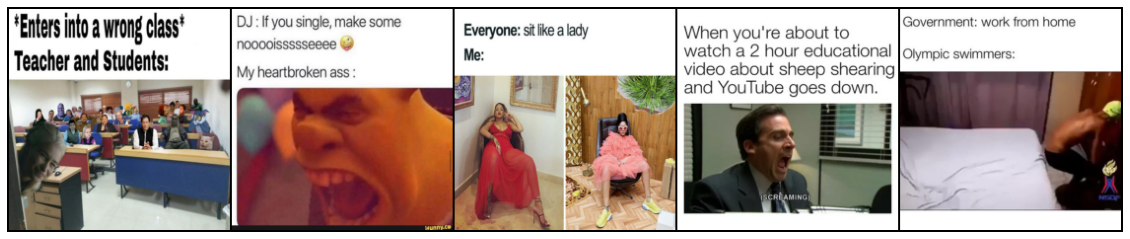

In [ ]:
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor()
    ]
)

# convert the images and prepare for visualization.
tensor_img = torch.stack(
    [image_transform(image) for image in images]
)
grid = torchvision.utils.make_grid(tensor_img)

# plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

In [ ]:
class MemesDataset(Dataset):

    def __init__(self,csv_file,root_dir,image_transform = None,text_transform = None):

        self.train_dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.text_transform = text_transform
        self.label_val = None

    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.train_dataframe)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.train_dataframe.loc[idx, "Id"]
        s = str(img_id) + ".jpg"
        image = Image.open(
            self.root_dir + '/train_images/' + s
        ).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image)
        text = None
        if self.text_transform:
            text = torch.Tensor(
                self.text_transform.get_sentence_vector(
                    self.train_dataframe.loc[idx, "ocr_text"]
                )
            ).squeeze()

        if "overall_sentiment" in self.train_dataframe.columns:
            label = self.train_dataframe.loc[idx, "overall_sentiment"]
            if label == "positive":
                self.label_val = torch.tensor(2)
            elif label == "negative":
                self.label_val = torch.tensor(0)
            else:
                self.label_val = torch.tensor(1)
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text, 
                "label": self.label_val
            }

        return sample

In [ ]:
dataset = MemesDataset(csv_file = path + '/memotion_train.csv',root_dir = path)
fig = plt.figure()
for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['image'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    if i == 3:
        plt.show()
        break

NameError: ignored

In [ ]:
import tempfile
from pathlib import Path

In [ ]:
def getImagePath(id, directory):

  return directory + str(id) + '.jpg'

In [ ]:
label_dict = {
    'negative':0,
    'positive':1,
    'neutral':2
}

class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data_path, 
        img_dir,
        image_transform = None,
        text_transform = None,
        random_state=0,
    ):

        self.samples_frame = pd.read_csv(data_path + '/memotion_train.csv')
        
        self.samples_frame = self.samples_frame.reset_index(drop=True)

        self.samples_frame['img'] = self.samples_frame.apply(
            lambda row: getImagePath(row.Id, img_dir), axis=1
        )
    
        self.image_transform = self._build_image_transform()
        self.text_transform = self._build_text_transform(data_path)

    def _build_text_transform(self,data_path):
        with tempfile.NamedTemporaryFile() as ft_training_data:
            ft_path = Path(ft_training_data.name)
            with ft_path.open("w") as ft:
                train_text = pd.read_csv(data_path + '/memotion_train.csv')

                training_data = list(train_text['ocr_text'])

                for line in training_data:
                    ft.write(line + "\n")

                language_transform = fasttext.train_unsupervised(
                    str(ft_path),
                    model=self.hparams.get("fasttext_model", "cbow"),
                    dim=self.embedding_dim
                )
        return language_transform
    
    def _build_image_transform(self):
        image_dim = 224
        image_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(
                    size=(image_dim, image_dim)
                ),        
                torchvision.transforms.ToTensor(),
                # all torchvision models expect the same
                # normalization mean and std
                # https://pytorch.org/docs/stable/torchvision/models.html
                torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)
                ),
            ]
        )
        return image_transform

    def __len__(self):
        
        return len(self.samples_frame)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "Id"]

        image = Image.open(
            self.samples_frame.loc[idx, "img"]
        ).convert("RGB")

        image = self.image_transform(image)

        text = torch.Tensor(
            self.text_transform.get_sentence_vector(
                self.samples_frame.loc[idx, "ocr_text"]
            )
        ).squeeze()

        # print('YESSSSSSSSSSSSS')
        # print(self.samples_frame.columns)
        if "overall_sentiment" in self.samples_frame.columns:

            # 

            label = torch.Tensor(
                [label_dict[self.samples_frame.loc[idx, "overall_sentiment"]]]
            ).long().squeeze()
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text, 
                "label": label
            }
        else:
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text
            }

        return sample

In [ ]:
dataset = HatefulMemesDataset(data_path = path,img_dir = path + '/train_images')
fig = plt.figure()
for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['image'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    if i == 3:
        plt.show()
        break

AttributeError: ignored

In [ ]:
class LanguageAndVisionConcat(torch.nn.Module):
    def _init_(
        self,
        num_classes,
        loss_fn,
        language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p,
        
    ):
        super(LanguageAndVisionConcat, self)._init_()
        self.language_module = language_module
        self.vision_module = vision_module
        
        self.fusion = torch.nn.Linear(
            in_features=(language_feature_dim + vision_feature_dim), 
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
        
    def forward(self, text, image, label=None):
        text_features = torch.nn.functional.relu(
            self.language_module(text)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, label) 
            if label is not None else label
        )
        return (pred, loss)

TypeError: ignored